In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexEntropy"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 512)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 512)

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [11]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, g

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.8min


[CV] .............. C=0.01, gamma=1e-08, score=0.139165, total= 4.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137795, total= 4.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138477, total= 4.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.137795, total= 4.1min
[CV] C=0.01, gamma=1e-06 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138889, total= 4.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.137695, total= 4.1min
[CV] .............. C=0.01, gamma=1e-08, score=0.139442, total= 4.1min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  7.8min


[CV] .............. C=0.01, gamma=1e-08, score=0.137695, total= 4.8min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.136986, total= 4.8min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137255, total= 4.8min
[CV] C=0.01, gamma=1e-05 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total= 4.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.138889, total= 4.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.138477, total= 4.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.139165, total= 4.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.1min


[CV] .............. C=0.01, gamma=1e-06, score=0.138477, total= 3.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.137795, total= 3.8min
[CV] C=0.01, gamma=0.0001 ............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138889, total= 3.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.138751, total= 3.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139442, total= 3.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.139165, total= 3.8min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.137695, total= 3.9min
[CV] C=0.01, gamma=0.001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 15.3min


[CV] .............. C=0.01, gamma=1e-05, score=0.138751, total= 4.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.334322, total= 4.5min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.336967, total= 4.5min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.337598, total= 4.5min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.139165, total= 4.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.138477, total= 4.7min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.139442, total= 4.6min
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 18.1min


[CV] .............. C=0.01, gamma=0.001, score=0.581373, total= 2.9min
[CV] .............. C=0.01, gamma=0.001, score=0.582677, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.564961, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.586548, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.590278, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.565907, total= 2.9min
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=0.001, score=0.571571, total= 2.9min
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 22.8min


[CV] C=0.01, gamma=1.0 ...............................................
[CV] ............... C=0.01, gamma=0.01, score=0.430392, total= 4.9min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.427300, total= 4.9min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.431275, total= 4.9min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.441468, total= 5.0min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.353516, total= 5.4min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.331703, total= 5.4min
[CV] C=0.01, gamma=10.0 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.321569, total= 4.5min
[CV] C

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 25.1min


[CV] ................ C=0.01, gamma=1.0, score=0.237305, total= 5.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.217647, total= 5.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.226027, total= 5.0min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.230315, total= 6.3min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.137255, total= 3.7min
[CV] ............... C=0.1, gamma=1e-08, score=0.136986, total= 3.7min
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.137695, total= 3.7min
[CV] C=0.1, gamma=1e-07 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 32.3min


[CV] ............... C=0.01, gamma=10.0, score=0.164706, total= 6.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.178150, total= 6.5min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.174430, total= 5.3min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.175299, total= 5.2min
[CV] ............... C=0.01, gamma=10.0, score=0.178571, total= 5.3min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.175944, total= 5.2min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.1, gamma=1e-08, score=0.138751, total= 3.7min
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 39.0min


[CV] ............... C=0.1, gamma=1e-07, score=0.137795, total= 4.2min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.137795, total= 4.3min
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138477, total= 4.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138889, total= 4.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.138751, total= 4.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.139165, total= 4.3min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-07, score=0.139442, total= 4.2min
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 42.5min


[CV] ............... C=0.1, gamma=0.001, score=0.839530, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.816929, total= 1.4min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.715134, total= 2.0min
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=0.001, score=0.830709, total= 1.4min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.733399, total= 2.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.723214, total= 2.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .............. C=0.1, gamma=0.0001, score=0.712724, total= 2.0min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 44.8min


[CV] ............... C=0.1, gamma=0.001, score=0.844708, total= 1.3min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.349206, total= 3.8min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.833333, total= 1.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.842418, total= 1.4min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.841948, total= 1.4min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=0.001, score=0.842629, total= 1.3min
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-05, score=0.348907, total= 4.2min
[CV] C=0.1, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 50.4min


[CV] ................. C=0.1, gamma=0.1, score=0.458661, total= 4.4min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.459941, total= 4.3min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.476710, total= 4.3min
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ................. C=0.1, gamma=0.1, score=0.466535, total= 4.7min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.496032, total= 4.4min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.494036, total= 4.8min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.484064, total= 4.8min
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 57.6min


[CV] ................ C=0.1, gamma=10.0, score=0.257874, total= 5.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.265084, total= 5.3min
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.276511, total= 5.3min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.136986, total= 3.9min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.291667, total= 5.4min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.137695, total= 4.2min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] ................ C=0.1, gamma=10.0, score=0.285288, total= 5.3min
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 64.4min


[CV] ............... C=1.0, gamma=1e-06, score=0.350294, total= 3.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.346680, total= 3.8min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.138889, total= 4.2min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.139165, total= 4.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-07, score=0.139442, total= 4.1min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.339216, total= 3.9min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-06, score=0.355315, total= 4.0min
[CV] C=1.0, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 66.9min


[CV] .............. C=1.0, gamma=0.0001, score=0.875371, total=  57.0s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.889990, total=  58.5s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.926758, total=  54.1s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] ............... C=1.0, gamma=0.001, score=0.934442, total=  54.2s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.878728, total=  57.8s
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.879960, total= 1.1min
[CV] C=1.0, gamma=0.01 ...............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.868526, total=  58.0s
[CV] C=1.0, gamma=0.1 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 71.7min


[CV] ................ C=1.0, gamma=0.01, score=0.799213, total= 3.5min
[CV] C=1.0, gamma=1.0 ................................................
[CV] ................ C=1.0, gamma=0.01, score=0.835984, total= 3.2min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.812686, total= 3.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.818452, total= 3.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................ C=1.0, gamma=0.01, score=0.831673, total= 3.4min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.611328, total= 4.2min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] ................. C=1.0, gamma=0.1, score=0.611765, total= 4.1min
[CV] C=1.0, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 79.5min


[CV] ................ C=1.0, gamma=10.0, score=0.367188, total= 5.5min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.365686, total= 5.8min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.375734, total= 5.8min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.353346, total= 5.7min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.352362, total= 5.4min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=10.0, score=0.350148, total= 5.3min
[CV] C=10.0, gamma=1e-07 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.137695, total= 4.4min
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 86.0min


[CV] .............. C=10.0, gamma=1e-06, score=0.737364, total= 2.1min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.721135, total= 2.2min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.875734, total= 1.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.871094, total= 1.0min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.340196, total= 4.2min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-06, score=0.726190, total= 2.2min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .............. C=10.0, gamma=1e-07, score=0.345472, total= 3.9min
[CV] C=10.0, gamma=0.0001 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 87.9min


[CV] ............. C=10.0, gamma=0.0001, score=0.915339, total=  31.0s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.924453, total=  34.6s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.889990, total=  54.3s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.868056, total=  54.2s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.871769, total=  58.1s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=0.001, score=0.935547, total=  47.1s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.864542, total=  59.1s
[CV] C=10.0, gamma=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 94.1min


[CV] ................ C=10.0, gamma=0.1, score=0.627451, total= 4.4min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.628937, total= 4.5min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.641865, total= 4.2min
[CV] C=10.0, gamma=10.0 ..............................................
[CV] ................ C=10.0, gamma=0.1, score=0.610287, total= 4.5min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.663022, total= 4.2min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.624381, total= 4.5min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] ................ C=10.0, gamma=0.1, score=0.636454, total= 4.6min
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 102.7min


[CV] ............... C=10.0, gamma=10.0, score=0.371514, total= 5.5min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............... C=10.0, gamma=10.0, score=0.401590, total= 6.0min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.717773, total= 2.0min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.721135, total= 2.0min
[CV] C=100.0, gamma=1e-06 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.706693, total= 2.0min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.705882, total= 2.1min
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.869141, total=  54.8s
[CV] C=100.0, gamma=1e-05 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 105.7min


[CV] ............. C=100.0, gamma=1e-05, score=0.914513, total=  36.9s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.918651, total=  38.1s
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.348907, total= 3.9min
[CV] C=100.0, gamma=0.001 ............................................
[CV] ............. C=100.0, gamma=1e-08, score=0.350598, total= 3.9min
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.870775, total=  58.9s
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-06, score=0.863546, total=  59.5s
[CV] C=100.0, gamma=0.01 .............................................
[CV] ............. C=100.0, gamma=1e-05, score=0.904382, total=  37.4s
[CV] C=100.0, gamma=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 110.6min


[CV] .............. C=100.0, gamma=0.01, score=0.827756, total= 3.3min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.823937, total= 3.3min
[CV] C=100.0, gamma=1.0 ..............................................
[CV] .............. C=100.0, gamma=0.01, score=0.826561, total= 3.3min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.828373, total= 3.2min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.846918, total= 3.2min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .............. C=100.0, gamma=0.01, score=0.839641, total= 3.3min
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............... C=100.0, gamma=0.1, score=0.628906, total= 4.2min
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 119.0min


[CV] ............ C=1000.0, gamma=1e-08, score=0.718504, total= 2.0min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .............. C=100.0, gamma=10.0, score=0.362205, total= 5.8min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.713155, total= 2.1min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.737364, total= 2.2min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-08, score=0.726190, total= 2.2min
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.868164, total=  58.3s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............ C=1000.0, gamma=1e-07, score=0.847059, total=  54.1s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 121.6min


[CV] ............ C=1000.0, gamma=1e-05, score=0.931507, total=  31.3s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-06, score=0.901394, total=  35.8s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.917323, total=  33.0s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.927451, total=  31.2s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.941929, total=  31.3s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.931615, total=  30.7s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] ............ C=1000.0, gamma=1e-05, score=0.918892, total=  31.3s
[CV] C=1000.0, gamma=0.01 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 135.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
top_model.cv_results_

{'mean_fit_time': array([ 247.52420609,  247.01164355,  229.99030199,  236.43998468,
         242.31905229,  162.59182146,  273.56315882,  263.89108021,
         339.28856561,  339.3658531 ,  209.99258428,  232.11710629,
         228.18205385,  218.89098845,  113.47613356,   73.03512013,
         196.3372993 ,  254.32867274,  309.22703061,  315.65562072,
         226.95577424,  230.33836842,  218.94063811,  112.55161748,
          49.60827911,   44.19925318,  189.36398957,  243.43469179,
         301.88748851,  317.37780094,  235.54934199,  227.29308715,
         114.04996755,   49.11537719,   27.59049873,   44.06012661,
         181.95441778,  248.01568787,  308.83756473,  326.12702544,
         224.9750622 ,  110.60557752,   50.1630347 ,   30.3208322 ,
          26.76196964,   44.88203781,  185.36516528,  247.6014287 ,
         314.0644592 ,  327.32845004,  109.54903104,   48.65103927,
          29.49484851,   26.14588959,   25.34000225,   42.04076791,
         185.82644207,  238.964

In [13]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.13822, std: 0.00079, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.33692, std: 0.00309, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.57439, std: 0.00930, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.43400, std: 0.00556, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.33998, std: 0.01212, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.23165, std: 0.00783, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.17374, std: 0.00411, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.13822, std: 0.00079, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [14]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.001} - score: 0.9427


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


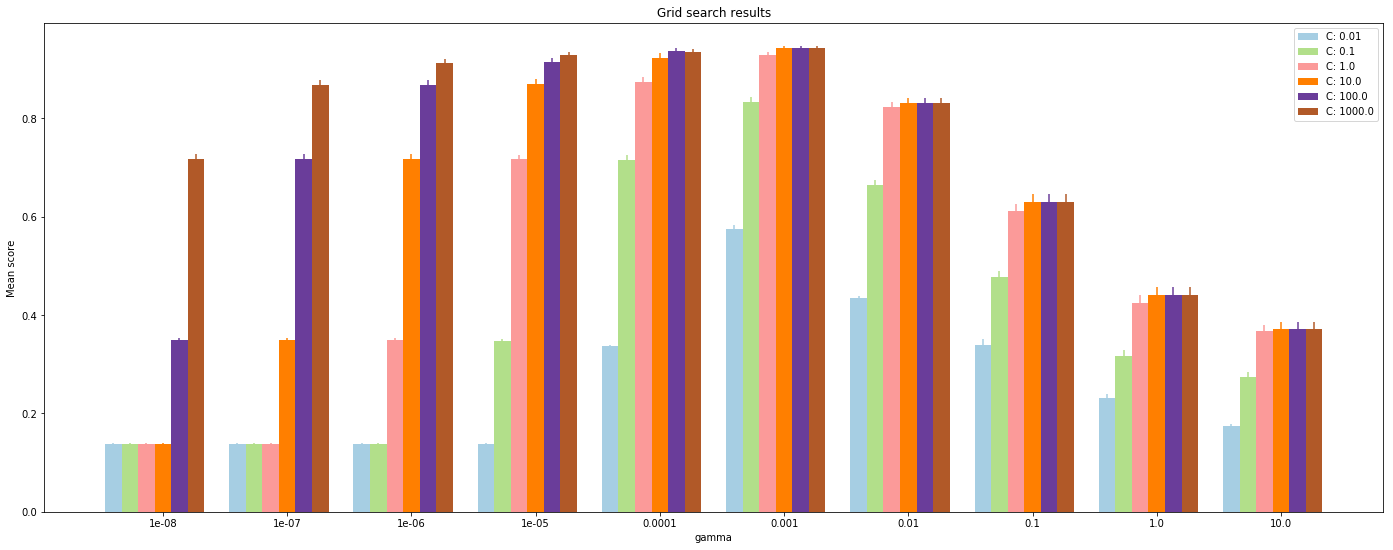

In [15]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()